In [1]:
library(shiny)
library(plyr)
library(shinyMatrix)
library(ggplot2)
library(grid)
library(gridExtra)
library(rgdal)
library(raster)
library(rgeos)
library(tools) 
library(leaflet)
library(sf)
library(tidyverse)
library(rdrop2)
library(rsconnect)
library(pryr)
library(JuliaCall)
# library(RPostgreSQL)
library(rpostgis)
# library(geojsonio)

setwd("/Users/work/Programming/Bats/circuitscape_app")


token <- drop_auth()
drop_auth(rdstoken = "my-token.rds") #for dropbox

Loading required package: sp

rgdal: version: 1.5-23, (SVN revision 1121)
Geospatial Data Abstraction Library extensions to R successfully loaded
Loaded GDAL runtime: GDAL 3.1.4, released 2020/10/20
Path to GDAL shared files: /Users/work/Library/R/4.0/library/rgdal/gdal
GDAL binary built with GEOS: TRUE 
Loaded PROJ runtime: Rel. 6.3.1, February 10th, 2020, [PJ_VERSION: 631]
Path to PROJ shared files: /Users/work/Library/R/4.0/library/rgdal/proj
Linking to sp version:1.4-5
To mute warnings of possible GDAL/OSR exportToProj4() degradation,
use options("rgdal_show_exportToProj4_warnings"="none") before loading rgdal.

rgeos version: 0.5-5, (SVN revision 640)
 GEOS runtime version: 3.8.1-CAPI-1.13.3 
 Linking to sp version: 1.4-2 
 Polygon checking: TRUE 


Linking to GEOS 3.8.1, GDAL 3.1.4, PROJ 6.3.1

── Attaching packages ────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.6     ✔ dplyr   1.0.4
✔ tidyr   1.1.2     ✔ stringr 1

Setup: inputs for the user are roost, radius and resolution. The radius is likely to be ~3-5km. groundrast is a raster that will be used for resampling resistance rasters, and also as input to circuitscape later on.

In [2]:
roost = c(274257,66207)
radius = 300
resolution = 1
xmax = roost[1]+radius
ymax = roost[2]+radius
xmin = roost[1]-radius
ymin = roost[2]-radius
ext <- extent(xmin,xmax,ymin,ymax)

ground_rast <- function(roost, radius, resolution) {
  #Generates a ground raster: NA everywhere except roost coordinates, used for resampling
  groundrast <- raster(xmn= roost[1] - radius,   # set minimum x coordinate
                       xmx = roost[1] + radius,    # set maximum x coordinate
                       ymn = roost[2] - radius,     # set minimum y coordinate
                       ymx = roost[2] + radius,     # set maximum y coordinate
                       res = c(resolution,resolution),
                       crs = NA) 
  roosts <- matrix(c(roost[1],roost[2]), nrow = 1, ncol = 2)
  groundrast <- rasterize(roosts,groundrast)
  writeRaster(groundrast, "gis-layers/ground.asc", overwrite=TRUE)
  groundrast
}

groundrast <- ground_rast(roost, radius, resolution)
groundrast

class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : NA 
source     : memory
names      : layer 
values     : 1, 1  (min, max)


Select the grid squares for OS maps that we need:

In [3]:
build_query_string <- function(tableName, ext) {
    xmin = attr(ext, "xmin")
    xmax = attr(ext, "xmax")
    ymin = attr(ext, "ymin")
    ymax = attr(ext, "ymax")
    envelope_params <- paste(xmin, ymin, xmax, ymax, 27700, sep=",")
    envelope <- paste("ST_MakeEnvelope(", envelope_params, ")")
    clip <- paste("ST_Intersection(", tableName, ".geom, ", envelope, ")", sep="")
    multi <- paste("ST_Multi(", clip, ") AS geom")
    query <- paste("SELECT ", multi, " FROM ", tableName, " WHERE ", tableName, ".geom && ", envelope, ";")
    return(query)
}

In [4]:
read_db_vector <- function(tableName, ext) {
    driver <- dbDriver("PostgreSQL")
    connection <- dbConnect(driver, dbname="os", port=5433)
    query = build_query_string(tableName, ext)
    results_sf <- pgGetGeom(connection, query=query)
    dbDisconnect(connection)
    return(results_sf)
}

In [5]:
output_dir = './gis-layers'

Road resistance: Download the correct shapefile from dropbox, crop to the extent we want and calculate resistance based on distance to the nearest road. 

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum OSGB 1936 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1

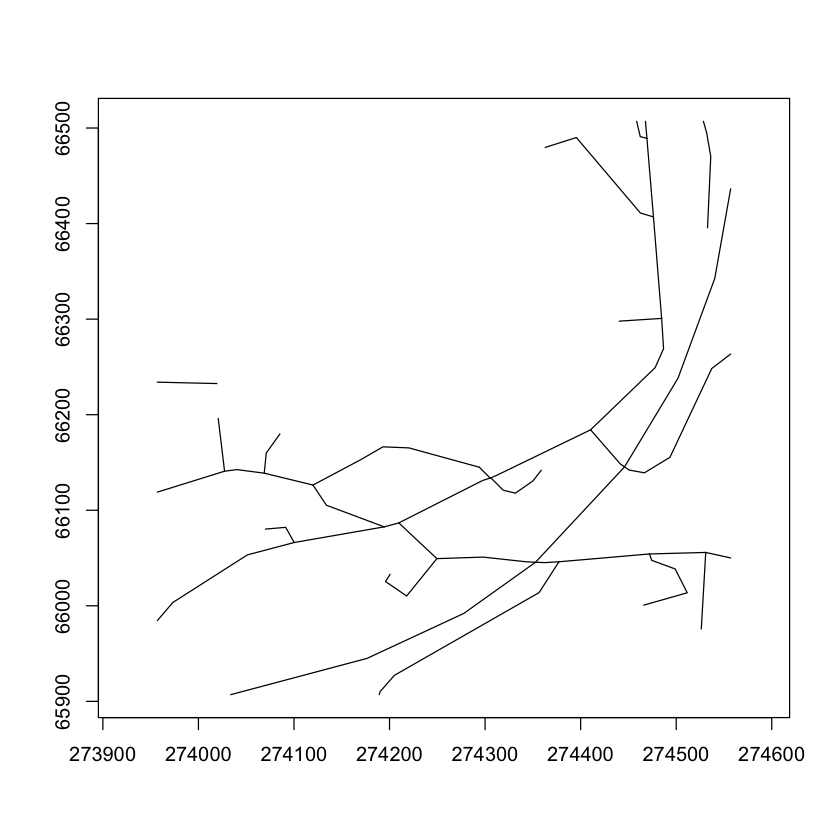

In [6]:
road <- read_db_vector("roads", ext)
plot(road, axes=TRUE)

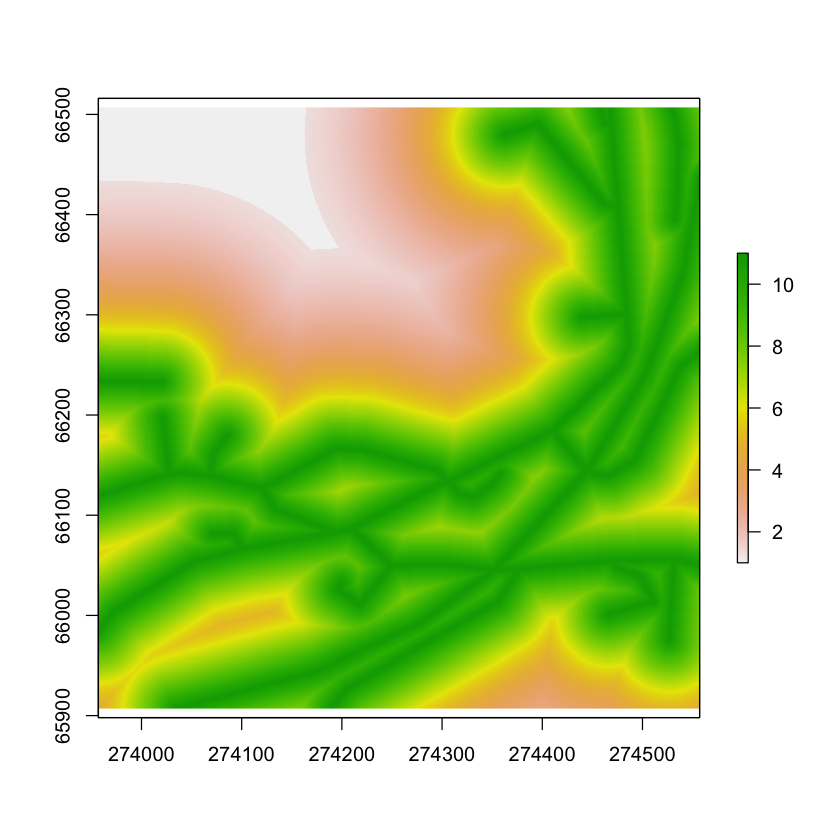

In [7]:
roadResistance <- function (roadRast){ 
    buffer <- 200 # meters to road
    Resmax <- c(10) #max resistance of layers
    Xmax <- c(5) #x is the slope value
    Rbuff <- 0
    r <- rasterize(road,groundrast)
    roadDistance <- distance(r)
    Rbuff <- 0
    resistance <- round(calc(roadDistance, function(Distance) {ifelse(Distance > buffer, Rbuff, (((1 - (Distance/buffer))*0.5 + 0.5)^Xmax)*Resmax)})+1, digits=3)
}

roadRes <- roadResistance(roadRast)
plot(roadRes)

In [8]:
roadRes
writeRaster(roadRes, "roadRes.tiff", "GTiff", overwrite=TRUE)

class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs 
source     : memory
names      : layer 
values     : 1, 11  (min, max)


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum OSGB 1936 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Returning MultiLineString types in SpatialLines*-class.



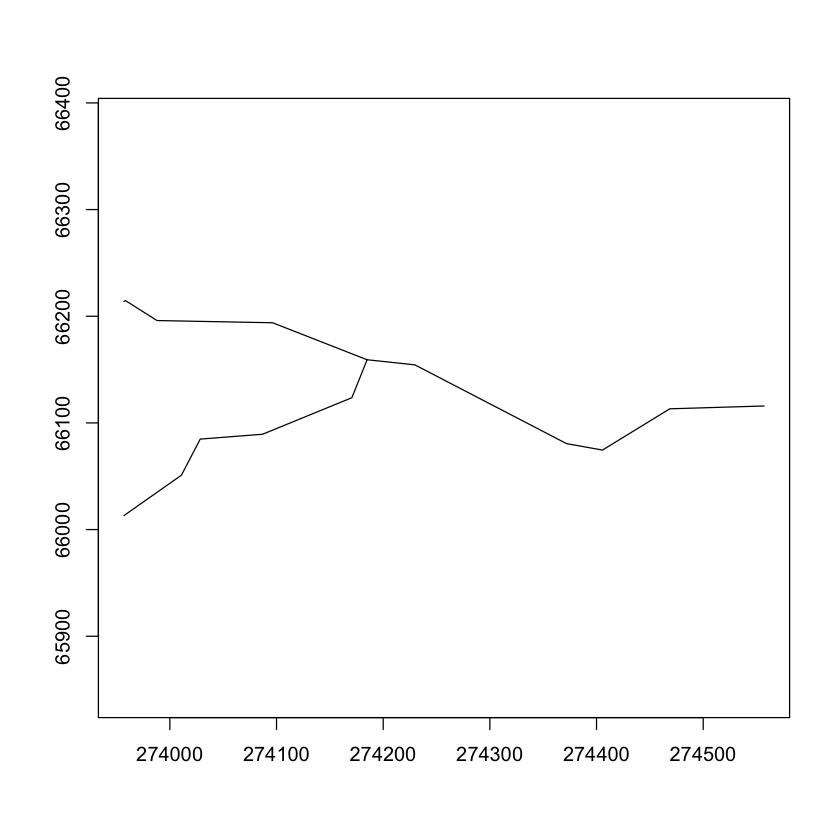

In [11]:
river <- read_db_vector("rivers", ext)
plot(river, axes=TRUE)

River resistance: Download the correct shapefile from dropbox, crop to the extent we want and calculate resistance based on distance to the nearest river. 

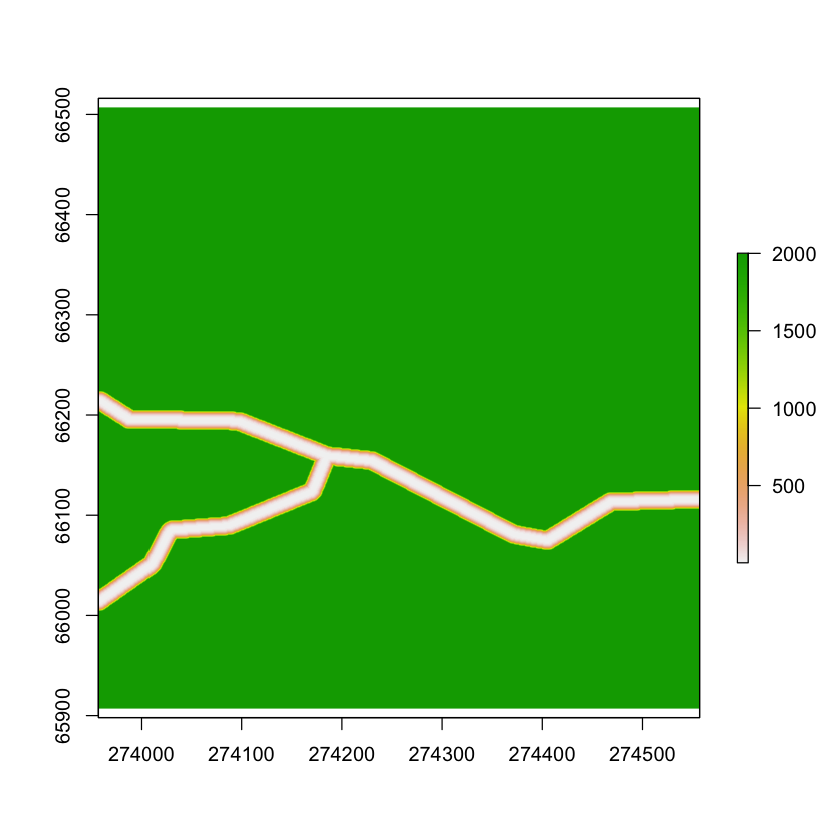

In [12]:
riverResistance <- function(river){  
    buffer <- 10
    Rankmax <- 1
    Resmax <- c(2000)
    Xmax <- c(4)
    Rbuff = Resmax
    r <- rasterize(river,groundrast)
    riverDistance <- distance(r)
    riverDistance[is.na(riverDistance)] <- 0
    resistance <- round(calc(riverDistance, function(Distance) {ifelse(Distance > buffer, Rbuff, ((Distance/buffer)^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    resistance[is.na(resistance)] <- 1
    resistance 
}

riverRes = riverResistance(river)
plot(riverRes)

In [13]:
riverRes
writeRaster(riverRes, "riverRes", "GTiff", overwrite=TRUE)

class      : RasterLayer 
dimensions : 600, 600, 360000  (nrow, ncol, ncell)
resolution : 1, 1  (x, y)
extent     : 273957, 274557, 65907, 66507  (xmin, xmax, ymin, ymax)
crs        : +proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +units=m +no_defs 
source     : memory
names      : layer 
values     : 1, 2001  (min, max)


Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”


Surfaces: lidar dtm and dsm rasters, used to calculate the height of objects above ground level. soft_surf = foliage, hard_surf = buildings. These are used for landcover, linear features and streetlights.

In [14]:
create_map <- function(tiles, groundrast) {
    #mosaic together multiple tiles for dtm/dsm maps
  composed <- lapply(tiles, raster)
  names(composed)[1:2] <- c('x', 'y')
  composed$na.rm <- TRUE
  composed$fun <- min
  map <- do.call(mosaic, composed)
  map <- resample(map, groundrast)
  return(map)
}

download_dm <- function(roost, radius, dm_dir, groundrast) {
  xmax <- round_any(as.numeric(roost[1])+radius, 1000, f = ceiling)
  xmin <- round_any(as.numeric(roost[1])-radius, 1000, f = floor)
  ymax <- round_any(as.numeric(roost[2])+radius, 1000, f = ceiling)
  ymin <- round_any(as.numeric(roost[2])-radius, 1000, f = floor)
  dm_dir <- paste0("gis-layers/",dm_dir)
  dir.create(dm_dir)
  iteration <- 1
  for (x in seq(xmin, xmax, by=1000)) {
    for (y in seq(ymin, ymax, by=1000)) {
      dmfilename <- paste0(dm_dir,"/",x,"/", y,".tif")
      if (drop_exists(dmfilename)){
        local_file <- paste0(dm_dir,"/",x,"_",y,".tif")
        drop_download(dmfilename, local_path = local_file, progress=FALSE, verbose=FALSE, overwrite=TRUE)
      }
      iteration <- iteration + 1
    }
  }
  create_map(list.files(dm_dir, full.names=TRUE), groundrast)
}

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum OSGB 1936 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1

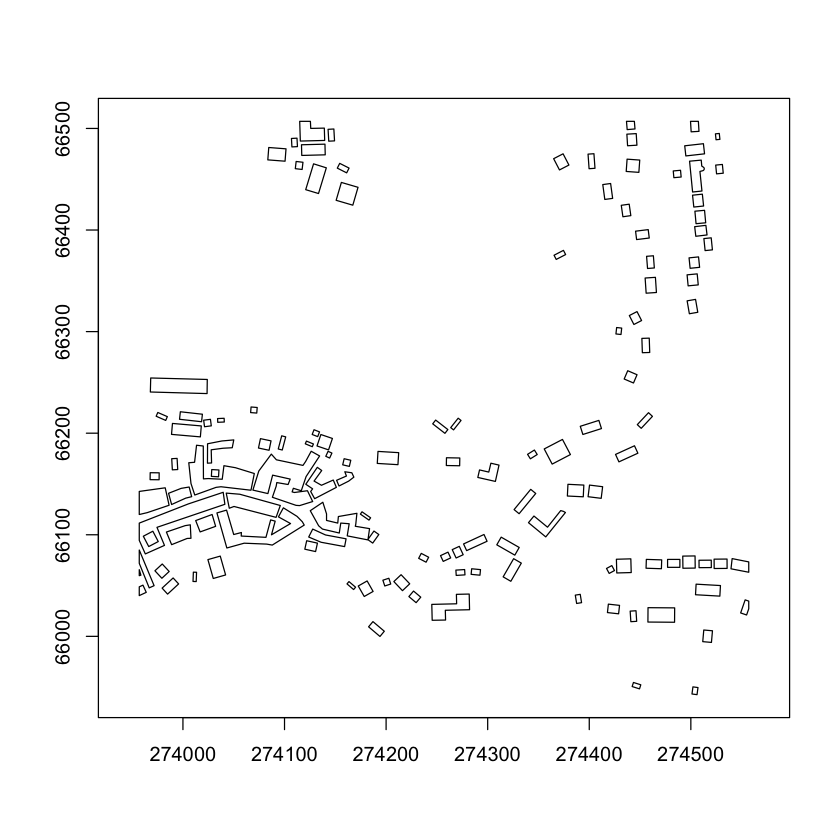

In [18]:
buildings <- read_db_vector("buildings", ext)
# buildings[!is.na(buildings)] <- 1
plot(buildings, axes=TRUE)

In [25]:
create_raster_query_boundary <- function(ext) {
    xmin = attr(ext, "xmin")
    xmax = attr(ext, "xmax")
    ymin = attr(ext, "ymin")
    ymax = attr(ext, "ymax")
    boundary = c(ymax, ymin, xmax, xmin)
    return(boundary)
}

In [26]:
read_db_raster <- function(table, ext) {
    name = c("public", table)
    boundary = create_raster_query_boundary(ext)
    driver <- dbDriver("PostgreSQL")
    connection <- dbConnect(driver, dbname="os", port=5433)
    raster <- pgGetRast(connection, name=name, boundary=boundary)
    dbDisconnect(connection)
    return(raster)
}

In [27]:
dsm = read_db_raster("dsm", ext)

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum OSGB 1936 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”


In [28]:
typeof(dsm)

[1] "S4"

In [23]:
dtm = read_db_raster("dtm", ext)

Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum OSGB 1936 in Proj4 definition”
Warning message in showSRID(uprojargs, format = "PROJ", multiline = "NO", prefer_proj = prefer_proj):
“Discarded datum Unknown based on Airy 1830 ellipsoid in Proj4 definition”


In [24]:
calc_surfs <- function(dtm, dsm, buildings){
  ### Returns surf, soft and hard surface rasters
  surf <- dsm - dtm
  
  soft_surf <- (buildings+1)*surf
  soft_surf[is.na(soft_surf)] <- 0
  soft_surf <- surf - soft_surf
  
  hard_surf <- buildings
  hard_surf[is.na(hard_surf)] <- 1
  hard_surf<- hard_surf * surf
  hard_surf <- abs(hard_surf - surf)
  return(c("surf"=surf,"soft_surf"=soft_surf,"hard_surf"=hard_surf))
}

filter_binary_layer <- function(value) {function(x, y){ifelse (y==1, value, x)}}

# dtm <- download_dm(roost, radius,"dtm", groundrast)
# dsm <- download_dm(roost, radius,"dsm", groundrast)

surfs <- calc_surfs(dtm, dsm, buildings)

ERROR: Error in buildings + 1: non-numeric argument to binary operator


Landcover: Resistance is ranked, buildings are the highest, hedgerows the lowest.

In [ ]:
ranked_resistance <- function(conductance, Rankmax, Resmax, Xmax) {
  resistance <- calc(conductance, fun=function(rank) {ifelse(rank == Rankmax, Resmax, (rank/Rankmax)^Xmax * Resmax)})
  resistance <- resistance + 1
  resistance <- round(resistance, digits = 3)
  resistance[is.na(resistance) == TRUE] <- 1
  return(resistance)
}


lcm <- resample(raster('gis-layers/lcmRank_sw.tif'),groundrast)
plot(lcm)

landscapeResistance_lcm <- function(lcm, buildings, soft_surf) {
  lidar_ranking <- c(-Inf, 0.5, 4,  # grass
                     0.5, 2.5, 3,   # scrub
                     2.5, Inf, 3)   # trees
  Resmax <- 100
  Xmax <- 5
  surfs$soft_surf[is.na(surfs$soft_surf)] <- 0
  conductance <- reclassify(surfs$soft_surf, lidar_ranking) + lcm
  Ranking <- maxValue(conductance)+1 #Max ranking: makes buildings the highest resistance
  rast <- buildings
  rast[!is.na(rast==TRUE)] <- 1.0 ## features
  rast[is.na(rast==TRUE)] <- 0.0 ## no features
  conductance <- overlay(conductance, rast, fun = filter_binary_layer(Ranking))
  resistance <- ranked_resistance(conductance, Rankmax, Resmax, Xmax)
}

landscapeRes = landscapeResistance_lcm(lcm, buildings, surfs$soft_surf)
plot(landscapeRes)

Linear features: hedgerows and trees. Resistance is based on distance from the nearest feature.

In [ ]:

prep_lidar_tifs <- function(surf,output_dir) { 
  #' Generates new rasters containing locations of:
  #' - manhedge.asc: managed hedgerows (height = 1m-3m above ground)
  #' - unmanhedge.asc: unmanaged hedgerows (height = 3m-6m above ground)
  #' - tree.asc: trees (height = 6m+ above ground)
  #' Add a buffer around all features of width 10m
  #' Then calculate the distance in each cell to the nearest feature
  #' Distance raster files are saved in directory output_dir
  
  manhedge <- surf
  manhedge[surf<3 & surf>1] <- 1
  manhedge[surf>=3] <- NA
  manhedge[surf<=1] <- NA
  manhedge <- buffer(manhedge,width=10,filename=paste(output_dir,"manhedge.asc",sep="/"),overwrite=TRUE)
  
  unmanhedge <- surf
  unmanhedge[surf<6 & surf>3] <- 1
  unmanhedge[surf>=6] <- NA
  unmanhedge[surf<=3] <- NA
  unmanhedge <- buffer(unmanhedge,width=10,filename=paste(output_dir,"umanhedge.asc",sep="/"),overwrite=TRUE)
  
  tree <- surf
  tree[surf>=6] <- 1
  tree[surf<6] <- NA
  tree <- buffer(tree,width=10,filename=paste(output_dir,"tree.asc",sep="/"),overwrite=TRUE)
  
  distance_rasters <- matrix(c(distance(unmanhedge),1,distance(tree),2,distance(manhedge),4),nrow=3,ncol=2)
  return(distance_rasters)
}

distance_resistance <- function(buffer, Rankmax, Rbuff, Resmax, Xmax, distance_rasters, effect) { 
  #' Calculates resistance raster given a distance raster
  raster_resistance <- distance_rasters[[1,1]]
  values(raster_resistance) <- 0
  for (i in nrow(distance_rasters)) {
    rast <- distance_rasters[[i,1]]
    Ranking <- distance_rasters[[i,2]]
    rast[is.na(rast) == TRUE] <- 0
    if (effect == "negative") {
      partial_resistance <- round(calc(rast, function(Distance) {ifelse(Distance > buffer, Rbuff, (((1 - (Distance/buffer))*0.5 + 0.5 *(Ranking/Rankmax))^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    }
    else {
      partial_resistance <- round(calc(rast, function(Distance) {ifelse(Distance > buffer, Rbuff, ((((Distance/buffer))*0.5 + 0.5 *(Ranking/Rankmax))^Xmax)*Resmax)})+1, digits=3) #this is the function: distance/ranks in traffic 
    }
    raster_resistance <- overlay(partial_resistance, raster_resistance, fun = max)  
  }
  raster_resistance[is.na(raster_resistance) == TRUE] <- 1
  raster_resistance
}


linearResistance <- function(surf){ 
  distance_rasters <- prep_lidar_tifs(surf,output_dir)
  buffer <- 10
  Rankmax <- 4
  Resmax <- c(22000)
  Xmax <- c(3)
  Rbuff <- Resmax[1]
  resistance <- distance_resistance(buffer, Rankmax, Rbuff, Resmax, Xmax, distance_rasters, "positive")
  resistance
}

linearRes = linearResistance(surfs$soft_surf)
plot(linearRes)

Lights resistance: point irradiance calculated using the method from here: https://besjournals.onlinelibrary.wiley.com/doi/pdfdirect/10.1111/2041-210X.12182, the code is from the supplementary material.

In [ ]:

lampResistance <- function(lamps,soft_surf,hard_surf,dtm){
  ext <- 100
  Resmax <- c(1e8)
  Xmax <- c(1)
  point_irradiance <- calc_point_irradiance(lamps,soft_surf,hard_surf,dtm)
  outputfile <- "light_resistance.asc"
  resistance <- light_resistance(Resmax, Xmax, point_irradiance, outputfile,extent_file)
  return(resistance)
}


lightdist <- function(xdist,ydist,zdist,theta=NULL) {
  xyzdist <- sqrt(xdist^2+ydist^2+zdist^2)
  return(1/(xyzdist^2))
}

calc_point_irradiance<- function(lamps,soft_surf,hard_surf,terrain) {
  point_irradiance <- soft_surf
  values(point_irradiance) <- 0 
  ext <- 100
  sensor_ht <- 2.5
  absorbance <- 0.5  
  for(lamp in 1:dim(lamps)[1]) {
    
    x <- lamps$x[lamp]
    y <- lamps$y[lamp]
    z <- lamps$z[lamp]
    
    ### find dimensions of area of influence of light
    row <- rowFromY(hard_surf,min(max(y,ymin(hard_surf)),ymax(hard_surf)))
    col <- colFromX(hard_surf,max(min(x,xmax(hard_surf)),xmin(hard_surf)))
    col_min <- max(col-ext,1)
    col_max <- min(col+ext,colFromX(hard_surf,xmax(hard_surf)))
    col_lamp <- col-col_min
    row_min <- max(row-ext,1)
    row_max <- min(row+ext,rowFromY(hard_surf,ymin(hard_surf)))
    row_lamp <- row-row_min
    nrows <- row_max-row_min
    ncols <- col_max-col_min
    
    ### extract terrain data for area of influence of light 
    hard_block <- array(getValuesBlock(hard_surf,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    soft_block <- array(getValuesBlock(soft_surf,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    terrain_block <- array(getValuesBlock(terrain,row=row_min,nrows=nrows,col=col_min,ncols=ncols),c(nrows,ncols))
    hard_block[is.na(hard_block==TRUE)] <- 0
    soft_block[is.na(soft_block==TRUE)] <- 0
    terrain_block[is.na(terrain_block==TRUE)] <- 0
    point_irrad <- array(0,c(ncols,nrows))
    ### find values for irradiance on a horizontal plane and sphere
    if (ncols==200&nrows==200) {
      for(xx in 1:ncols) {
        for (yy in 1:nrows) {
          xdist <- col_lamp-xx
          ydist <- row_lamp-yy
          xydist <- sqrt(xdist^2+ydist^2)
          zdist <- (terrain_block[row_lamp,col_lamp]+z)-(terrain_block[yy,xx]+sensor_ht)
          xyzdist <- sqrt(xydist^2+zdist^2)
          dist <- floor(xydist+0.5)
          if (xydist<=ext && zdist>0 && is.na(hard_block[yy,xx])==FALSE && dist>0) {
            shadow <- 1
            shading <- 0
            for (d in 1:dist) {
              if(hard_block[as.integer(yy+(ydist)*(d/dist)),as.integer(xx+(xdist)*(d/dist))] >= (terrain_block[yy,xx]+sensor_ht+(d/dist)*zdist)) {
                shadow <- 0
                break
              }
              if(soft_block[as.integer(yy+(ydist)*(d/dist)),as.integer(xx+(xdist)*(d/dist))] >= (terrain_block[yy,xx]+sensor_ht+(d/dist)*zdist)) {
                shading <- shading + xyzdist/xydist
              }
              point_irrad[xx,yy] <- (1/(10^(absorbance*shading)))*shadow*lightdist(xdist,ydist,zdist)
            }
          }
        }
      }
      point_values <- raster(point_irrad,xmn=xFromCol(point_irradiance,col_min),ymn=yFromRow(point_irradiance,row_max),xmx=xFromCol(point_irradiance,col_max),ymx=yFromRow(point_irradiance,row_min))
      origin(point_values) <- origin(point_irradiance)
      point_irradiance <- mosaic(point_irradiance,point_values,fun=sum)
      removeTmpFiles()
    }
  }
  writeRaster(point_irradiance,filename=paste("point_irradiance.tif"),overwrite=TRUE)
  return(point_irradiance)
}

light_resistance <- function(Resmax, Xmax, rast, outputfile,extent_file) {
  print(Resmax)
  rast[is.na(rast==TRUE)] <- 0
  MaxPI <- maxValue(rast)
  raster_resistance <- round(calc(rast, fun=function(PI) {((PI/MaxPI)^Xmax)*Resmax}) + 1, digits = 3)
  raster_resistance[is.na(raster_resistance) == TRUE] <- 1
  writeRaster(raster_resistance, filename = outputfile, NAflag=-9999, overwrite=TRUE)
  raster_resistance
}

    lamps <- read.csv(file="gis-layers/lights.csv", col.names=c("x","y","z"))
    colnames(lamps) <- c("x","y","z")
    ext <- 100
    lamps <- lamps[(lamps$x-roost[1])^2 + (lamps$y-roost[2])^2 < (radius+ext)^2,]
 plot(lamps$x,lamps$y)

lampRes <- lampResistance(lamps,surfs$soft_surf,surfs$hard_surf,dtm) 
plot(lampRes)

Prepare inputs to circuitscape: ground raster, source raster, resistance raster. Total resistance is the sum of individual resistances.

In [ ]:
totalRes = lampRes+roadRes+linearRes+riverRes+landscapeRes
writeRaster(totalRes, "resistance.asc",overwrite=TRUE)
plot(totalRes)

In [ ]:
circles = groundrast
values(circles) = 0

  for (r in seq(50,radius,50)) {
      angle = 2*pi*(0:(3*r))/(3*r)
    df <- data.frame( x = roost[1]+r*sin(angle),
                  y = roost[2]+r*cos(angle))
      points = SpatialPoints(df, proj4string=CRS(as.character(NA)), bbox = NULL) 
    circles = circles + rasterize(points, groundrast,background=0)
  }
circles[circles>0]=1
  writeRaster(circles,'source.asc',NAflag=-9999,overwrite=TRUE)
plot(circles)

Run circuitscape and plot: 

JuliaCall isn't working for me at the moment, so I ran Circuitscape in Julia:

    using Circuitscape
    
    current = compute("cs.ini")

In [ ]:
#julia_call("compute", "cs.ini")

In [ ]:
current = raster('cs_out_curmap.asc')
plot(current)

In [ ]:
    bng <- '+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +datum=OSGB36 +units=m +no_defs'
 
crs(current) <- bng
    pal <- colorNumeric("RdYlBu", values(log(current)),
                        na.color = "transparent")
    bngcrs <- leafletCRS(crsClass = "L.Proj.CRS", code = "ESRI:102003",
                         proj4def = bng,
                         resolutions = 1.5^(25:15))
    proj = data.frame(x = roost[1], y = roost[2]) %>% 
      st_as_sf(coords = 1:2, crs = 27700) %>%
      st_transform(4326) %>%
      st_coordinates()%>%
      as_tibble()
    labels=c("Low"," " , "",  "High")
    m <- leaflet() %>%
      addProviderTiles(providers$Stamen.Toner, options = providerTileOptions(opacity = 0.5)) %>%
         addLegend("bottomright", pal = pal, values = values(log(current)), bins = 4, 
                title = "Current",
                opacity = 0.8,
                labFormat = function(type, cuts, p) { 
                  paste0(labels)
                }
      
      ) %>%
      addMarkers(lng=proj$X, lat=proj$Y, popup="Roost")%>%
    addRasterImage(log(current), colors = pal, opacity = 0.9)
# m